In [1]:
import json
import folium
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from osgeo import ogr
    
from mpl_toolkits.basemap import Basemap
from numpy import array
from matplotlib.path import Path
import matplotlib.patches as patches
%matplotlib inline
driver = ogr.GetDriverByName("OpenFileGDB")

ds = driver.Open("/Users/rishuvaid/Desktop/data/Zone19_2009_11.gdb", 0)
 


In [2]:

#boston
min_x= -71.1461
min_y= 42.5662
max_x= -70.2974
max_y= 42.0880
#new_bedford
# min_x= -70.9648
# min_y=  41.8164
# max_x=-70.6119
# max_y=41.4458
map = Basemap(llcrnrlon=min_x ,llcrnrlat=max_y,urcrnrlon=max_x,urcrnrlat=min_y,resolution='c',projection='tmerc',lat_0=29.40,lon_0=-68.83)

minx,miny=map(min_x,min_y,inverse=False)
maxx,maxy=map(max_x,max_y,inverse=False)
layerr=ds.GetLayer()
ex_tent=[minx,miny,maxx,maxy]


layerr.SetSpatialFilterRect(min_x,min_y,max_x,max_y)




In [3]:
voyage_arrays={}
for feat in layerr:
    geom = feat.GetGeometryRef()
    if feat.GetField("VoyageID") not in voyage_arrays:
        voyage_arrays[feat.GetField("VoyageID")]=[[geom.GetX()],[geom.GetY()]]
    else:
        voyage_arrays[feat.GetField("VoyageID")][0].append(geom.GetX())
        voyage_arrays[feat.GetField("VoyageID")][1].append(geom.GetY())




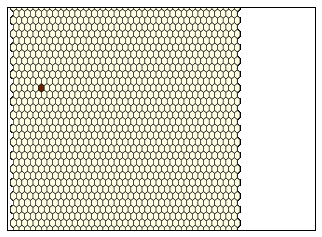

In [4]:
hex_dict={}
hex_count={}
for voyage in voyage_arrays.keys():
    x,y=map(voyage_arrays[voyage][0],voyage_arrays[voyage][1],inverse=False)
    hex_dict[voyage]=map.hexbin(array(x),array(y),gridsize=40,linewidths=0.5, edgecolors='k',cmap='YlOrBr', mincnt=0,extent=ex_tent)
    hex_count[voyage]=hex_dict[voyage].get_array()


hex_keys=list(hex_dict.keys())

y=[]
for i,c in enumerate(hex_count[hex_keys[0]]):
    sum=0
    for f in hex_keys:
        if(hex_count[f][i] != 0):
            sum+=1
    y.append(sum)

     
     
    
#     get geometry cords from first voyage in the dictionary (since geometry is fixed)
    
paths=hex_dict[hex_keys[0]].get_paths()[0]
cordinates=list(paths.iter_segments())
centers=hex_dict[hex_keys[0]].get_offsets()


hex_collection={"type":"FeatureCollection"}
hex_collection['features']=[]
for x,i in enumerate(centers):
    if(y[x] != 0):
        binx,biny = centers[x][0],centers[x][1]
        hex_cord={}
        cord_arr=[]

        for cord in cordinates:
            cords=[]
            off_x=float(cord[0][0])+float(binx)
            off_y=float(cord[0][1])+float(biny)
            lon,lat=map(off_x,off_y,inverse=True)
            cords.append(lon)

            cords.append(lat)
            cord_arr.append(cords)
        hex_cord["id"]=str(x)
        hex_cord["type"]="Feature"
        hex_cord["geometry"]={"type":"Polygon"}
        hex_cord["properties"]={}
        hex_cord["properties"]["count"]=y[x]
        hex_cord["geometry"]["coordinates"]=[cord_arr]
        hex_collection['features'].append(hex_cord)




In [9]:
import json
with open('bos_nov.geojson', 'w') as outfile:
    json.dump(hex_collection, outfile)



data = pd.DataFrame([[feature['id'],feature['properties']['count']] for feature in hex_collection['features']], columns=['FID','FCOUNT'])
boston1=[{}]
for index, row in data.iterrows():
    boston1[0][row['FID']]=row['FCOUNT']
with open('bos_nov.json', 'w') as outfile:
    json.dump(boston1, outfile)

#layerr.SetAttributeFilter("BaseDateTime > '2008/12/31 00:00:00' AND BaseDateTime < '2009/01/08 00:00:00'")
#layerr.SetAttributeFilter("BaseDateTime > '2009/01/07 00:00:00' AND BaseDateTime < '2009/01/15 00:00:00'")
#layerr.SetAttributeFilter("BaseDateTime > '2009/01/14 00:00:00' AND BaseDateTime < '2009/01/22 00:00:00'")
#layerr.SetAttributeFilter("BaseDateTime > '2009/01/21 00:00:00' AND BaseDateTime < '2009/02/01 00:00:00'")

interval=20
thresh = [data['FCOUNT'].min() + val*interval for val in range(int((data['FCOUNT'].max()-data['FCOUNT'].min())/interval))]




In [10]:
#####################   FOR DISPLAY   #######################


from IPython.core.display import HTML
def inline_map(m, width=950, height=800):
    """Takes a folium instance and embed HTML."""
    m._build_map()
    srcdoc = m.HTML.replace('"', '&quot;')
    embed = HTML('<iframe srcdoc="{}" '
                 'style="width: {}px; height: {}px; '
                 'border: none"></iframe>'.format(srcdoc, width, height))
    return embed
dcmap2=folium.Map(location=[min_y,min_x])
dcmap2.geo_json(geo_path='bos_nov.geojson',key_on='feature.id',
    data=data,
    columns=['FID','FCOUNT'],
    fill_color='YlOrRd',threshold_scale=thresh)
dcmap2.lat_lng_popover()
dcmap2


/Users/rishuvaid/anaconda/lib/python3.4/site-packages/folium/folium.py:504: UserWarning: This method is deprecated. Please use Map.choropleth instead.
  warnings.warn('This method is deprecated. '
/Users/rishuvaid/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:18: FutureWarning: lat_lng_popover is deprecated. Use add_children(LatLngPopup) instead


In [ ]:
#     min_x= -70.9305
#     min_y= 43.1060
#     max_x=-70.4388
#     max_y= 42.6754